# Training a visual prosthesis using Convolutional Neural Network

## 1/ Context
Retinal implants are ....

import some images

In [1]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import tree
import os
import random

mpl.rc('image', cmap='gray_r')
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.datasets import mnist

C:\Users\MariO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2/ The first-test transformation: a one row translation to the left
For the first try, we use a translation transformation based on a 4 by 4 pixels image in black and white.
We can easily build the transformation matrices that will generate the "mangled" image based on a real input, as well as the transformation that will generate the corrected input.

$ P = \begin{bmatrix} 0 & 0 & 0 &1\\
                      1 & 0 & 0 & 0\\
                      0 & 1 & 0 & 0\\
                      0 & 0 & 1 & 0
        \end{bmatrix} $ and 
$ P^{\star} = \begin{bmatrix} 0 & 1 & 0 &0\\
                      0 & 0 & 1 & 0\\
                      0 & 0 & 0 & 1\\
                      1 & 0 & 0 & 0
        \end{bmatrix} $
        
$M_{mangled} = M_{real}P $ and  $M^{\star} = M_{real}P^{\star} $

In [2]:
# Transformation matrices
P = np.array([[0, 0, 0, 1],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
Pstar = np.array([[0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [1, 0, 0, 0]])

In [3]:
# real image
Mreal = np.array([[0, 0, 0, 0],
                  [0, 1, 1, 0],
                  [0, 1, 1, 0],
                  [0, 1, 1, 0]])
Mreal = np.ones((4,4)) - Mreal
# distorted image
Mmang = Mreal@P
# corrected input
Mstar = Mreal@Pstar


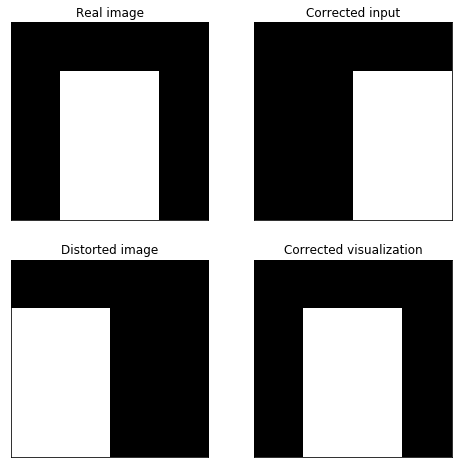

In [4]:
# plt.figure(1)
def remove_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off    
    return

def vis_matrices(Mr, Mm, Mst, MstM):
#     print(Mr.shape[0])
    if Mr.shape[0]==1:
        Mr = Mr.reshape(int(np.sqrt(Mr.shape[1])), int(np.sqrt(Mr.shape[1])))
        Mm = Mm.reshape(int(np.sqrt(Mm.shape[1])), int(np.sqrt(Mm.shape[1])))
        Mst = Mst.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))
        MstM = MstM.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))

    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2) #, squeeze=True, sharey=True)
    fig.set_size_inches(8,8)

    plt.sca(ax1[0])
    plt.imshow(Mr)
    plt.title("Real image")
    remove_ticks()

    plt.sca(ax2[0])
    plt.imshow(Mm)
    plt.title("Distorted image")
    remove_ticks()

    plt.sca(ax1[1])
    plt.imshow(Mst)
    plt.title("Corrected input")
    remove_ticks()

    plt.sca(ax2[1])
    plt.imshow(MstM)
    plt.title("Corrected visualization")
    remove_ticks()
    
    
vis_matrices(Mreal, Mmang, Mstar, Mstar@P)

## 3/ Machine-Learning approach
We are using the Convolutional Neural Network applied to the MNIST (hand written number recognition).
This is a classification algorithm, meaning we cannot get an image as an output.
A turn-around is to train the model with N images of one pixel, the output is then the position of this pixel in the mangled image.

To use the trained model and predict mangled images or corrected input, we will this simply split up the input image into N images of one pixels and rebuild the result.

In [5]:
nbpix = 4

### 3.1/ Generating the training data
We create n x n images of one pixel and use the known $P$ and $P^{\star}$ matrices to generate the corresponding $M_{mangled}$ and $M_{star}$

In [10]:
def create_training_data(nbpix,nb_lvl_gray=1):
    """
    Build the set of one pixel matrices and apply the transformations
    """
    # List of indexes where to put a black pixel
    idx = range(0,nbpix**2,1)

    # Initialize empty arrays 
    Mreal_tab = np.zeros((len(idx),nbpix*nbpix))
    Mmang_tab = np.zeros((len(idx),nbpix*nbpix))
    Mstar_tab = np.zeros((len(idx),nbpix*nbpix))
    for ii in idx:
        # Fill the indexed pixel with a one
        Mreal_tab[ii,ii] = 1
        # Use the transformation matrices to generate Mmang and Mstar
        Mmang_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@P).reshape(1,nbpix**2)
        Mstar_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@Pstar).reshape(1,nbpix**2)
    return (Mreal_tab, Mmang_tab, Mstar_tab)

(Mreal_tab, Mmang_tab, Mstar_tab) = create_training_data(nbpix,1)
idx = range(0,nbpix**2,1)

Let's visualise one of the training image

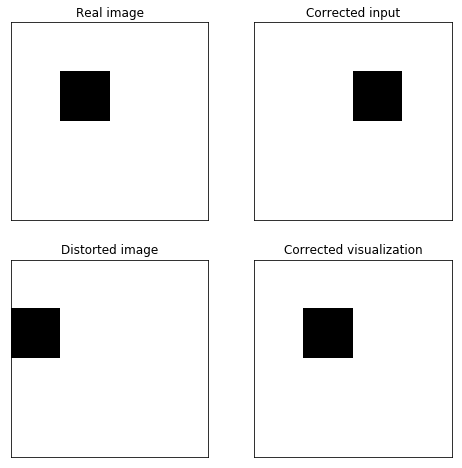

In [11]:
n = 5
vis_matrices(Mreal_tab[n,:].reshape(nbpix,nbpix),
             Mmang_tab[n,:].reshape(nbpix,nbpix), 
             Mstar_tab[n,:].reshape(nbpix,nbpix), 
             Mstar_tab[n,:].reshape(nbpix,nbpix)@P)    

In [12]:
# the training input are the matrices of the real images with one pixel
X_train = Mreal_tab

In [13]:
# the training output will be the category corresponding to the position of the pixel in the mangled image
y_train = [np.where(Mmang_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train = to_categorical(y_train, nbpix**2)

# or the position of the pixel in the corrected image
y_train_cor = [np.where(Mstar_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train_cor = to_categorical(y_train_cor, nbpix**2)

### 3.2/ Create and train the models
We are going to create one model that 

In [14]:
# creating the models
model_mangler = Sequential()
model_mangler.add(Dense(100, activation='relu', input_dim=nbpix**2))
model_mangler.add(Dense(100, activation='relu'))
model_mangler.add(Dense(nbpix**2, activation='softmax'))
# Inversion strategy doesnt work very well...
# we are going to try using another model, trained on the corrected input.
model_corrector = Sequential()
model_corrector.add(Dense(100, activation='relu', input_dim=nbpix**2))
model_corrector.add(Dense(100, activation='relu'))
model_corrector.add(Dense(nbpix**2, activation='softmax'))

In [15]:
# Compile the models
model_mangler.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model_corrector.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [16]:
print("Model 'Mangler'")
print(model_mangler.summary())
print("Model for corrected input")
print(model_corrector.summary())

Model 'Mangler'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
Total params: 13,416
Trainable params: 13,416
Non-trainable params: 0
_________________________________________________________________
None
Model for corrected input
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________

In [17]:
# train the model "mangler"
model_mangler.fit( X_train,
    y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
 - 0s - loss: 2.7715 - acc: 0.0625
Epoch 2/100
 - 0s - loss: 2.7553 - acc: 0.0625
Epoch 3/100
 - 0s - loss: 2.7341 - acc: 0.0625
Epoch 4/100
 - 0s - loss: 2.7136 - acc: 0.2500
Epoch 5/100
 - 0s - loss: 2.6935 - acc: 0.3125
Epoch 6/100
 - 0s - loss: 2.6737 - acc: 0.3125
Epoch 7/100
 - 0s - loss: 2.6541 - acc: 0.3750
Epoch 8/100
 - 0s - loss: 2.6347 - acc: 0.5000
Epoch 9/100
 - 0s - loss: 2.6154 - acc: 0.6250
Epoch 10/100
 - 0s - loss: 2.5959 - acc: 0.6250
Epoch 11/100
 - 0s - loss: 2.5764 - acc: 0.7500
Epoch 12/100
 - 0s - loss: 2.5566 - acc: 0.8125
Epoch 13/100
 - 0s - loss: 2.5365 - acc: 0.8750
Epoch 14/100
 - 0s - loss: 2.5160 - acc: 0.8750
Epoch 15/100
 - 0s - loss: 2.4953 - acc: 0.9375
Epoch 16/100
 - 0s - loss: 2.4743 - acc: 0.9375
Epoch 17/100
 - 0s - loss: 2.4527 - acc: 0.9375
Epoch 18/100
 - 0s - loss: 2.4306 - acc: 0.9375
Epoch 19/100
 - 0s - loss: 2.4077 - acc: 0.9375
Epoch 20/100
 - 0s - loss: 2.3845 - acc: 0.9375
Epoch 21/100
 - 0s - loss: 2.3607 - acc: 0.9375
E

In [18]:
# train the corrected input model
model_corrector.fit( X_train,
    y_train_cor,
    epochs=100,
    shuffle=True,
    verbose=2
)    

Epoch 1/100
 - 0s - loss: 2.7842 - acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 2.7609 - acc: 0.0625
Epoch 3/100
 - 0s - loss: 2.7381 - acc: 0.1250
Epoch 4/100
 - 0s - loss: 2.7158 - acc: 0.1250
Epoch 5/100
 - 0s - loss: 2.6937 - acc: 0.2500
Epoch 6/100
 - 0s - loss: 2.6723 - acc: 0.3750
Epoch 7/100
 - 0s - loss: 2.6511 - acc: 0.5000
Epoch 8/100
 - 0s - loss: 2.6303 - acc: 0.5625
Epoch 9/100
 - 0s - loss: 2.6097 - acc: 0.5625
Epoch 10/100
 - 0s - loss: 2.5890 - acc: 0.6875
Epoch 11/100
 - 0s - loss: 2.5684 - acc: 0.6875
Epoch 12/100
 - 0s - loss: 2.5475 - acc: 0.7500
Epoch 13/100
 - 0s - loss: 2.5262 - acc: 0.9375
Epoch 14/100
 - 0s - loss: 2.5045 - acc: 0.9375
Epoch 15/100
 - 0s - loss: 2.4825 - acc: 1.0000
Epoch 16/100
 - 0s - loss: 2.4600 - acc: 1.0000
Epoch 17/100
 - 0s - loss: 2.4370 - acc: 1.0000
Epoch 18/100
 - 0s - loss: 2.4135 - acc: 1.0000
Epoch 19/100
 - 0s - loss: 2.3895 - acc: 1.0000
Epoch 20/100
 - 0s - loss: 2.3649 - acc: 1.0000
Epoch 21/100
 - 0s - loss: 2.3399 - acc: 1.00

### 3.3/ Use the models to predict the mangled image and corrected input

Split the Mreal matrix into n matrices of one pixel:

In [19]:
# Function to add one on the designated index
def add_one(arr,index):
    arr[0,index] = 1
    return arr

# Function to split the matrix into matrices of one pixel
def split_matrix(mat):
    """ Split a matrix into matrices of one pixel"""
    # find the indexes of the ones values in the matrix
    idx_arr = np.where(mat.reshape(1,nbpix**2)[0]==1)[0]
    # transform from an array to a list
    idx_lst = [idx_arr.item(ii) for ii in range(0,len(idx_arr))] 
    temp = np.zeros((1,nbpix**2))
    mat_split = np.zeros((len(idx_lst), nbpix**2))
#     Mtest = np.zeros((nbpix,nbpix))
    for ii in range(0,len(idx_lst)):
        mat_split[ii,idx_lst[ii]] = 1    
#         Mtest = Mtest + Mreal_split[ii,:].reshape(nbpix,nbpix)
    return mat_split

Mreal_split = split_matrix(Mreal)
# Mreal_split

Use the trained models to predict the mangled response and the corrected input response of all of these one pixel images
and then rebuild the full image by adding up all the result matrixes.

In [20]:
# Prediction functions
def predict_mangler(mat):
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
        res[ii,:] = model_mangler.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres

def predict_corrector(mat):
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
        res[ii,:] = model_corrector.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres
    


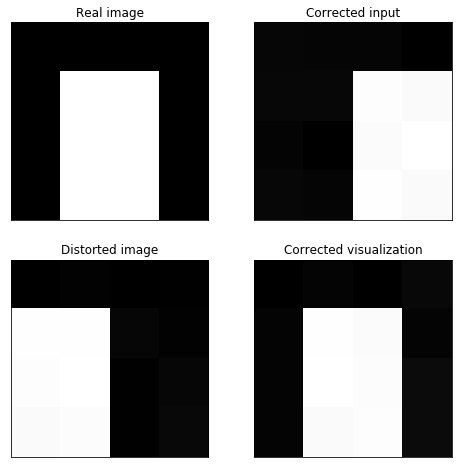

In [21]:
# Predict the mangled image based on the real one
Mmang_ml = predict_mangler(Mreal)
# Predict the corrected input based on the real image
Mcor_ml = predict_corrector(Mreal)
# Prediction the output from the corrected input
Mout_ml = predict_mangler(np.round(Mcor_ml))
# plot the results
vis_matrices(Mreal, Mmang_ml,Mcor_ml, Mout_ml)


## 4/ Increase the nb of pixels

In [ ]:
# # nb of pixels considered into the picture
# nbpix = 6
# transform_type = "translation"
# nb_lvl_gray = 1

In [ ]:
# # Transformation matrices

# if transform_type is "translation":
#     # nb of pixels translated
#     nbt = int(np.round(0.25*nbpix))

#     # bottom left square block
#     bl = np.eye(nbpix-nbt,nbpix-nbt)
#     # upper right square block
#     ur = np.eye(nbt,nbt)
#     # upper left rect block
#     ul = np.zeros((nbt,nbpix-nbt))
#     # bottom right rect block
#     br = np.zeros((nbpix-nbt,nbt))

#     # concatenate the blocks to build the transformation matrix
#     P = np.concatenate((np.concatenate((ul,ur), axis=1), np.concatenate((bl,br), axis=1)), axis=0)
#     Pstar = np.linalg.inv(P)


In [ ]:
# # Create the training data
# (Mreal_tab, Mmang_tab, Mstar_tab) = create_training_data(nbpix,nb_lvl_gray)

# X_train = Mreal_tab

# # the training output will be the category corresponding to the position of the pixel in the mangled image
# y_train = [np.where(Mmang_tab[ii,:]==1)[0].item(0) for ii in idx]
# y_train = to_categorical(y_train, nbpix**2)

# # or the position of the pixel in the corrected image
# y_train_cor = [np.where(Mstar_tab[ii,:]==1)[0].item(0) for ii in idx]
# y_train_cor = to_categorical(y_train_cor, nbpix**2)
# y_train.shape

In [ ]:
# # creating the models
# model_mangler = Sequential()
# model_mangler.add(Dense(100, activation='relu', input_dim=nbpix**2))
# model_mangler.add(Dense(100, activation='relu'))
# model_mangler.add(Dense(nbpix**2, activation='softmax'))
# # Inversion strategy doesnt work very well...
# # we are going to try using another model, trained on the corrected input.
# model_corrector = Sequential()
# model_corrector.add(Dense(100, activation='relu', input_dim=nbpix**2))
# model_corrector.add(Dense(100, activation='relu'))
# model_corrector.add(Dense(nbpix**2, activation='softmax'))

# # Compile the models
# model_mangler.compile(loss="categorical_crossentropy",
#               optimizer="adam", metrics=['accuracy'])
# model_corrector.compile(loss="categorical_crossentropy",
#               optimizer="adam", metrics=['accuracy'])



In [ ]:
# # train the model "mangler"
# model_mangler.fit( X_train,
#     y_train,
#     epochs=100,
#     shuffle=True,
#     verbose=2
# )

In [ ]:
# # train the corrected input model
# model_corrector.fit( X_train,
#     y_train_cor,
#     epochs=100,
#     shuffle=True,
#     verbose=2
# ) 

- an artificial feed-forward-type multi-layer neural network configured, e.g., using the Error-Backpropagation algorithm; 
- a Hopfield-type Attractor neural network configured with, e.g., the Projection Rule or the Pseudoinverse algorithm; 
- and/or a recurrent neural network trained, e.g., with algo rithms such as Real-Time Recurrent Learning algorithm and the Time-Dependent Recurrent Backpropagation to determine a vision solution. 